In [83]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import pandas as pd

In [84]:
import gc

def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            #print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2'], img['B8']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

def sort_dict_by_date(
    images_dicts : Union[Dict, None]
) -> List:
    """
    Sorted the Images Dict keys' to make a time series analysis.
    """
    # Get all the keys of the dictionary.
    dates_list = [(key, re.findall(f"(\d+)T", key)[0]) for key in images_dicts.keys()]
    # Cast the keys to daterimes.
    datetimes_list = [(date[0], datetime.strptime(date[1], '%Y%m%d')) for date in dates_list]
    # Sort the tuples based on the datetimes.
    datetimes_list = sorted(datetimes_list, key = lambda x: x[1])
    # Extract just the sorted keys.
    keys_sorted_list = [key[0] for key in datetimes_list]

    return keys_sorted_list

def stack_to_dict(
    stack: Union[np.stack, None],
    bands: List[str] = ['B4','B3','B2','B8']
) -> Dict:
    """
    Unstack the rescaled dictionary.
    """
    dimension = stack.shape

    # Create the arrays of the bands.
    bands_lst = [[] for band in bands]
    
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            # R
            bands_lst[0].append(
                stack[i][j][0]
            )
            # G
            bands_lst[1].append(
                stack[i][j][1]
            )
            # B
            bands_lst[2].append(
                stack[i][j][2]
            )
            # NIR
            bands_lst[3].append(
                stack[i][j][3]
            )
    
    # Create
    unstack_dict = {bands[i] : bands_lst[i]  for i in range(len(bands))}
            
    return unstack_dict

def get_center_pixels(image_data,l = 3):
    """
    Zooms in the center of the location with a square l times
    """
    diag_length=(l,l)
    drawing = image_data.copy()
    h, w, _ = image_data.shape
    rows, cols = diag_length
    
    center = (round(h/2), round(w/2))

    square = image_data[center[0]-cols:center[0]+cols, center[1]-rows:center[1]+rows]

    cv2.rectangle(drawing, (center[0]-cols, center[1]-rows), (center[0]+cols, center[1]+rows), (255, 255, 255))
    plt.imshow(drawing)

    return square

def calculate_ndvi(image_data):
    r = 6 #reshaper
    b4 = np.array(image_data["B4"]).reshape(r,r,1)
    b8 = np.array(image_data["B8"]).reshape(r,r,1)

    visr = b4.astype("float64")
    nir = b8.astype("float64")

    ndvi_matrix=np.where((nir+visr)==0., 0, (nir-visr)/(nir+visr))
    
    # fig, ax = plt.subplots()
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)

    # im = ax.imshow(ndvi_matrix, cmap='viridis')
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # plt.show()

    return ndvi_matrix

def calculate_wdrvi(image_data,a=0.1):
    r = 6 #reshaper
    b4 = np.array(image_data["B4"]).reshape(r,r,1)
    b8 = np.array(image_data["B8"]).reshape(r,r,1)

    visr = b4.astype("float64")
    nir = b8.astype("float64")

    ndvi_matrix=np.where((nir+visr)==0., 0, (a*nir-visr)/(a*nir+visr))
    
    # fig, ax = plt.subplots()
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)

    # im = ax.imshow(ndvi_matrix, cmap='viridis')
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # plt.show()

    return ndvi_matrix

def calculate_savi(image_data, L=0.5):
    r = 6 #reshaper
    b4 = np.array(image_data["B4"]).reshape(r,r,1)
    b8 = np.array(image_data["B8"]).reshape(r,r,1)

    visr = b4.astype("float64")
    nir = b8.astype("float64")

    savi_matrix=np.where((visr+nir + L)==0., 0, ((nir-visr)/(visr+nir + L) ) * (1+L))

    # fig, ax = plt.subplots()
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    
    # im = ax.imshow(savi_matrix, cmap='RdYlGn')

    # fig.colorbar(im, cax=cax, orientation='vertical')
    # plt.show()

    return savi_matrix

def calculate_gci(image_data):
    r = 6 #reshaper
    b3 = np.array(image_data["B4"]).reshape(r,r,1)
    b8 = np.array(image_data["B8"]).reshape(r,r,1)

    visg = b3.astype('float64')
    nir = b8.astype('float64')

    gci_matrix=np.where((visg)==0., 0, (nir)/(visg) - 1)

    # fig, ax = plt.subplots()
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # im = ax.imshow(gci_matrix, cmap='RdYlGn')
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # plt.show()

    return gci_matrix

def calculate_index_avg(index_matrix):
    return index_matrix.flatten().sum()/len(index_matrix.flatten())

def generate_ndvi_time_series(images):

    values = []

    for image in sort_dict_by_date(images):
        img = convert_to_eight_bits(images[image])
        representative_region = get_center_pixels(img)
        representative_region_bands = stack_to_dict(representative_region)
        index_calculation = calculate_ndvi(representative_region_bands)
        average = calculate_index_avg(index_calculation)

        values.append(average)

    return values

def generate_savi_time_series(images):

    values = []

    for image in sort_dict_by_date(images):
        img = convert_to_eight_bits(images[image])
        representative_region = get_center_pixels(img)
        representative_region_bands = stack_to_dict(representative_region)
        index_calculation = calculate_savi(representative_region_bands)
        average = calculate_index_avg(index_calculation)

        values.append(average)

    return values

def generate_gci_time_series(images):


    values = []

    for image in sort_dict_by_date(images):
        img = convert_to_eight_bits(images[image])
        representative_region = get_center_pixels(img)
        representative_region_bands = stack_to_dict(representative_region)
        index_calculation = calculate_gci(representative_region_bands)
        average = calculate_index_avg(index_calculation)

        values.append(average)
    #normalization
    norm = [float(i)/max(values) for i in values] 
    return norm

def generate_wdrvi_time_series(images):
    

    values = []

    for image in sort_dict_by_date(images):
        img = convert_to_eight_bits(images[image])
        representative_region = get_center_pixels(img)
        representative_region_bands = stack_to_dict(representative_region)
        index_calculation = calculate_wdrvi(representative_region_bands)
        average = calculate_index_avg(index_calculation)

        values.append(average)
    #normalization
    norm = [float(i)/max(values) for i in values] 
    return norm

def one_var_regression(time_series):
    x = np.linspace(1,240,len(time_series))
    y = time_series
    model_function = np.poly1d(np.polyfit(x,y,5))
    line = x

    plt.figure()
    plt.scatter(x,y,None,"b")
    plt.plot(line,model_function(line),"r")
    plt.legend(["Index","Polynomial regression"])
    
    return model_function

In [85]:
IMGS_PATH = 'D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data-1\DataExtraction\DataBase\Manitoba1-1'
band_labels = ["B4", "B3", "B2", "B8"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

In [86]:
test = convert_to_eight_bits(images[img_keys[0]])

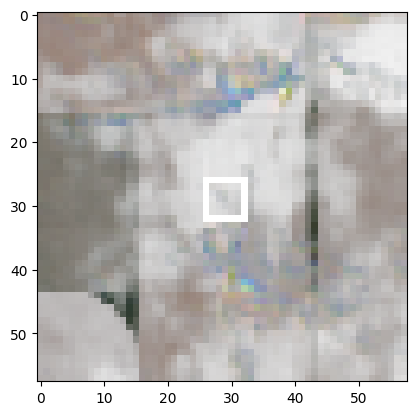

In [87]:
test_region = get_center_pixels(test)

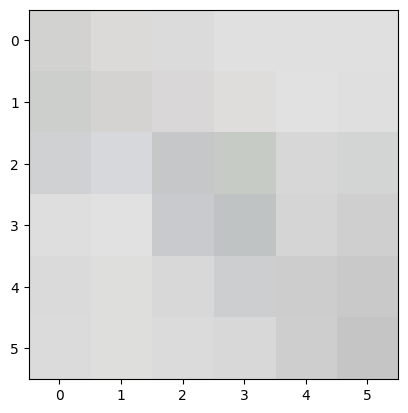

In [88]:
plt.imshow(test_region)